In [1]:
# libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import datetime

# Assign device depending on the machine capabilities
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
batch_size = 128

# MNIST Dataset

# Load data without normalization
#train_dataset = datasets.MNIST(root ='./mnist_data/', train = True, transform = transforms.ToTensor(), download = True)
#test_dataset = datasets.MNIST(root ='./mnist_data/', train = False, transform = transforms.ToTensor(), download = False)

# Load data with normalization

train_dataset = datasets.MNIST(root = './mnist_data', train=True, 
                                   transform = transforms.Compose([
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize((0.1306,), (0.3081,))
                                                                  ]), download = True)
test_dataset = datasets.MNIST(root = './mnist_data/', train=False, 
                                  transform=transforms.Compose([
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize((0.1325,), (0.3105,))
                                                              ]), download = False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
class AE(nn.Module):
    def __init__(self, input_dim, encoder_layer_sizes, decoder_layer_sizes, latent_dim, num_labels=10):
        """
        Arguments:
            input_dim (int): dimension of the input.
            encoder_layer_sizes (list[int]): list with the sizes of the encoder layers.
            decoder_layer_sizes (list[int]): list with the sizes of the decoder layers.
            latent_dim (int): dimension of latent space/bottleneck.
            num_labels (int): number of labels.
        """
        super(AE, self).__init__()
        
        # the output dim is the same as the input dim
        self.input_dim   = input_dim
        
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        
        self.encoder = Encoder(encoder_layer_sizes, latent_dim)
        self.decoder = Decoder(decoder_layer_sizes, latent_dim)
        
    def forward(self, x):
        """
        Forward Process of the whole AE. 
        Arguments:
            x: tensor of dimension (batch_size, input_dim).
        Outputs: 
            x_reconstructed: reconstructed input (output of the autoencoder).
                Same dimension as x (batch_size, input_dim).
        """
        
        # Map the input to the latent space (encoding)
        z = self.encoder(x)
        
        # Map the latent variable to the input/output space (decoding), 
        # i.e., get the reconstruction from the latent space
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed

class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim):
        super(Encoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of the linear layers of the encoder.
            latent_dim (int): dimension of latent space, i.e. dimension out output of the encoder.
        """
        
        # Hidden layers
        self.hidden = nn.ModuleList()
        for k in range(len(layer_sizes)-1):
            self.hidden.append(nn.Linear(layer_sizes[k], layer_sizes[k+1]))
        
        # Output layer from the encoder
        self.out = nn.Linear(layer_sizes[-1], latent_dim)
            
    
    def forward(self, x):  
        """
        Makes the forward for the Encoder.
        Arguments:
            x: input of the autoencoder, tensor of dimension (batch_size, 28*28).
 
        Outputs:
            z: latent variable, tensor of dimension (batch_size, latent_dim).
        """
        
        # Do the feedforward for the hidden layers
        for layer in self.hidden:
            x = F.relu(layer(x))
            
        # Do the feedforward for the output layer
        # to get the latent space variable
        
        #z = F.relu(self.out(x))
        
        z = self.out(x)
        
        return z
    
    
class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim):     
        super(Decoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of the linear layers of the decoder.
            latent_dim (int): dimension of latent space, i.e. dimension out input of the decoder.
             
        """
        
        # Hidden layers
        self.hidden = nn.ModuleList()
        
        if len(layer_sizes) > 1:
            # Append the first layer of the decoder
            self.hidden.append(nn.Linear(latent_dim, layer_sizes[0]))
            # Append the layers in between
            for k in range(len(layer_sizes)-2):
                self.hidden.append(nn.Linear(layer_sizes[k], layer_sizes[k+1]))
            # Append the last layer which considers the last element
            # from the list of layer_sizes, this could be done in the for loop
            # but it's done that way for the sake of neatness
            self.out = nn.Linear(layer_sizes[-2], layer_sizes[-1])
        else:
            self.out = nn.Linear(latent_dim, layer_sizes[-1])
            
    def forward(self, z):
        """
        Makes the forward for the Decoder.
        Arguments:
            z: tensor of dimension (batch_size, latent_dim).
        Outputs:
            x: reconstructed input from the latent space of dimension (batch_size, input_dim).
        """
        # Do the feedforward for the hidden layers
        x = z
        for layer in self.hidden:
            x = F.relu(layer(x))
            
        # Do the feedforward for the output layer
        # to get the reconstruction
        
        x = F.relu(self.out(x))
        
        return x

def L1_regularization(autoencoder, x, lambda_):
    """
    Computes the L1 regularization loss for the autoencoder (sparse autoencoder).
    Arguments:
        autoencoder: autoencoder in which the training is being run.
        x: input tensor.
        lambda_ : hyperparameter to scale the regularization term.
    Outputs:
        loss_L1: L1 regularization loss for the autoencoder.
      
    """
    loss_L1 = 0
    # Get the hidden layers from the encoder and the decoder
    linear_layers_encoder = list(model.encoder.children())
    linear_layers_decoder = list(model.decoder.children())
    # Most of the layers are embedded in a nn.ModuleList(), therefore
    # we have to get them from the index 0 in the list of linear layers. 
    hidden_layers = list(linear_layers_encoder[0]) + [linear_layers_encoder[1]] + list(linear_layers_decoder[0])
    for h_layer in hidden_layers:
        x = F.relu(h_layer(x))
        loss_L1 += torch.mean(torch.abs(x)) # get the mean of the batch
    
    # scale by lambda
    loss_L1 *= lambda_
    
    return loss_L1

def loss_function (x, x_reconstructed, autoencoder, lambda_, regularization = None):
    """
    Computes the loss_function of the autoencoder.
    Arguments:
        x_reconstructed: reconstruced input.
        x: input tensor.
        autoencoder: autoencoder in which the training is being run.
        lambda_: hyperparameter to scale the regularization term.
        regulariztion: Type of regularization. It can take the following values:
            'None': Without regularization.
            'L1'  : L1 regularization.
            'KL_divergence': KL divergence regularization.
    Outputs:
        loss_batch: loss of the batch depending on the type of the regularization used.
      
    """
    # Compute the MSE loss
    loss_MSE = nn.MSELoss()
    loss_batch = loss_MSE (x, x_reconstructed)
    if regularization is not None:
        if regularization == 'L1':
            loss_L1  = L1_regularization (autoencoder, x, lambda_)
            loss_batch += loss_L1
        if regularization == 'KL_divergence':
            pass
    
    return loss_batch

In [4]:
def imshow(img_original, img_reconstructed):
    """
    Plots the original image and the reconstructed image side by side.
    Arguments:
        img_original: original image from the dataset.
        img_reconstructed: reconstructed image, output of the autoencoder.
    """
    f = plt.figure()
    
    # plot the original image
    f.add_subplot(1,2, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title("Original image")
    plt.xticks([])
    plt.yticks([])
    # plot the reconstructed image
    f.add_subplot(1,2, 2)
    plt.imshow(img_reconstructed, cmap='gray')
    plt.title("Reconstructed image")
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def plot_X2D_visualization(X_2D, labels, title, num_classes):
    """
    Plots the visualization of the latent space, by separating the classes.
    Arguments:
        X_2D: data in the latent space(2D).
        labels: true labels of the data.
        title: string with the title of the graphic.
        num_classes: Number of classes.
    """
    plt.figure(figsize=(10,10))
    for i in range(num_classes):
        idx = np.where(labels == i)
        plt.scatter(X_2D[idx, 0], X_2D[idx, 1], cmap='viridis')
    
    list_legend = [ "class {}".format(i) for i in range(num_classes) ]
    plt.legend(list_legend)
    plt.title(title)
    plt.show()
    return None

def run_PCA(X, n_components = 2):
    """
    Runs PCA given the data (numpy array).
    Arguments:
        X: data in the in high dimension.
        n_components: Number of components to keep.
    """
    pca = PCA(n_components = n_components)
    X_2D_pca = pca.fit(X).transform(X)
    
    return X_2D_pca

def split_data_loader(data_loader):
    """
    Splits the data loader into data (X) and labels(Y).
    Arguments:
        data_loader: data loader.
    """
    X = None # array to store data
    Y = None # array to store labels
    for batch_idx, data in enumerate(data_loader):
        x, y = data
        x = x.reshape(x.shape[0], -1)
        if batch_idx == 0:
            X = x
            Y = y
        else:
            X = np.vstack((X, x))
            Y = np.hstack((Y,  y))
            
    return X.squeeze(), Y
    

In [6]:
# Define the lists with the sizes for the layers
# of the encoder and decoder
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]

# Define the dimension of the latent space and the input space
#latent_dim = 4 # this is the minimum number, s.t. the images can be reconstructed
latent_dim = 2
input_dim  = 784

# Define the model as an autoencoder
model = AE(input_dim = input_dim, encoder_layer_sizes=encoder_layer_sizes, 
           decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)

model = model.to(device)

# Use Adam optmizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
# Training of the AE
def train(num_epochs):
    model.train()
    print("Starting training...")
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            x, y = data
            x = x.to(device)
            
            # Resize the input accordingly
            x = x.view(-1, input_dim)
            optimizer.zero_grad()
            
            # Get the reconstrunction from the autoencoder
            x_reconstructed = model(x)
            
            # Compute the loss of the batch
            loss = loss_function(x, x_reconstructed, model, lambda_ = 1e-3, regularization = 'L1')
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(datetime.datetime.now(), end = '\t')
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(y), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item() / len(y)))
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    print("Training DONE!")
    
    return None
    

# Call the training 
num_epochs = 20
train(num_epochs) 

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.007869
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.005541
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.005083
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.005065
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.004820
====> Epoch: 0 Average loss: 0.0053
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.004472
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.004791
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.004617
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.004782
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.004597
====> Epoch: 1 Average loss: 0.0047
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.004573
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.004617
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.004386
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.004370
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.004580
====> Epoch: 2 Average loss: 0.0046
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.004404
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.004227
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.004556
Train Epoch:

Batch: 0


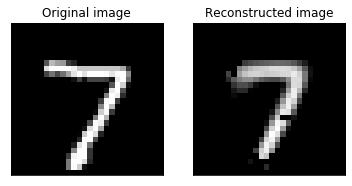

Batch: 1


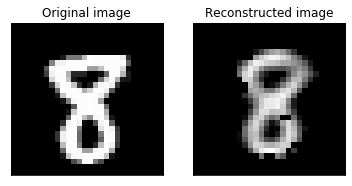

Batch: 2


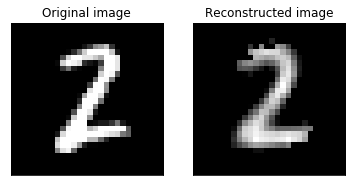

Batch: 3


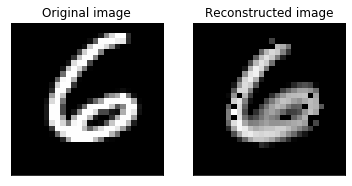

Batch: 4


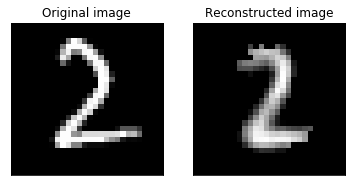

Batch: 5


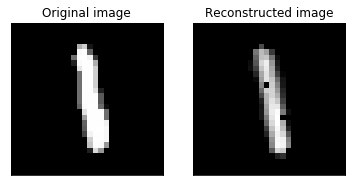

Batch: 6


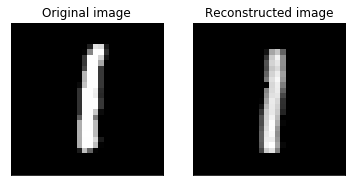

Batch: 7


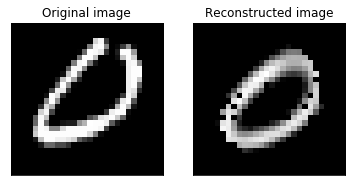

Batch: 8


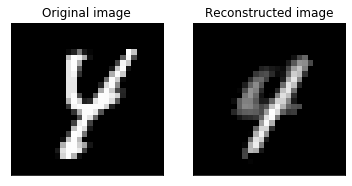

Batch: 9


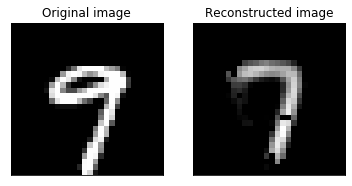

Batch: 10


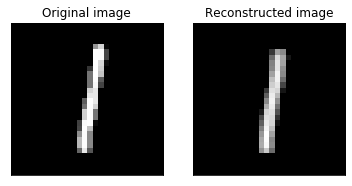

Batch: 11


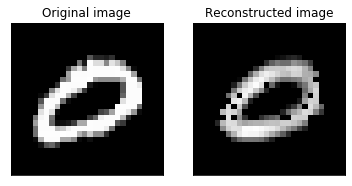

Batch: 12


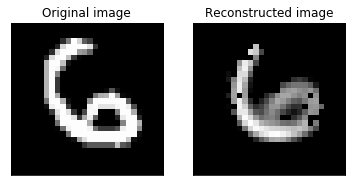

Batch: 13


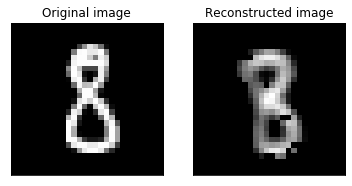

Batch: 14


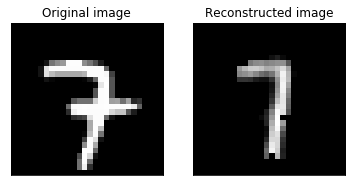

Batch: 15


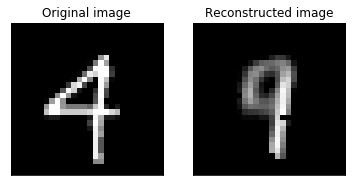

Batch: 16


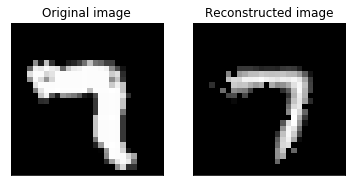

Batch: 17


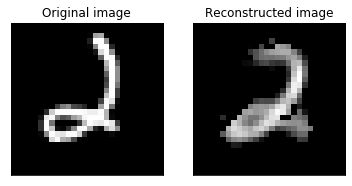

Batch: 18


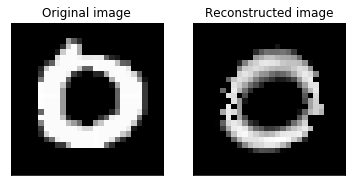

Batch: 19


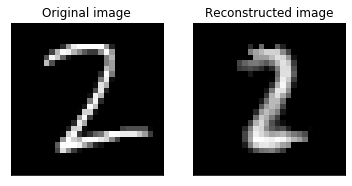

Batch: 20


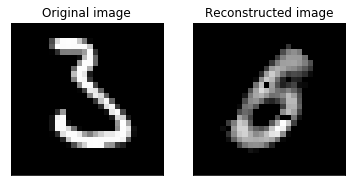

Batch: 21


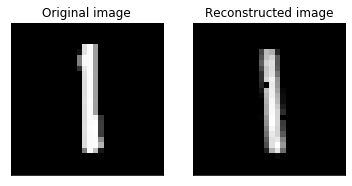

Batch: 22


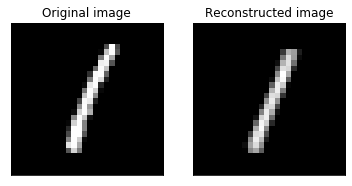

Batch: 23


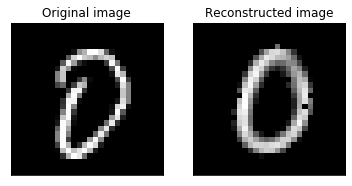

Batch: 24


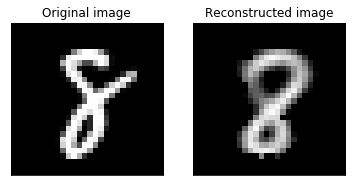

Batch: 25


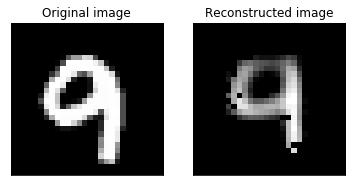

Batch: 26


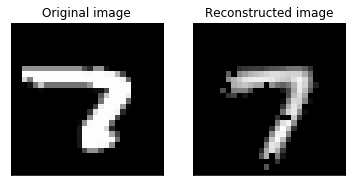

Batch: 27


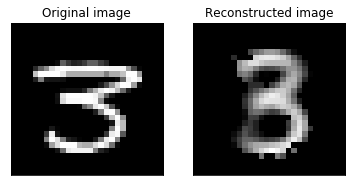

Batch: 28


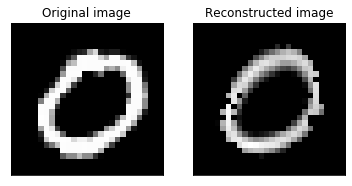

Batch: 29


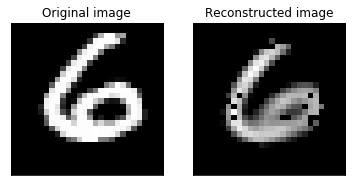

Batch: 30


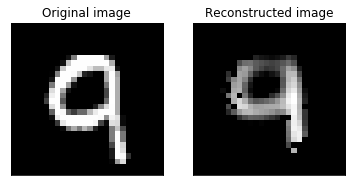

Batch: 31


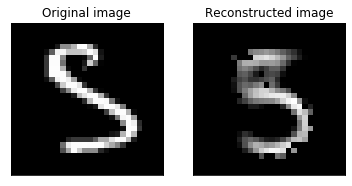

Batch: 32


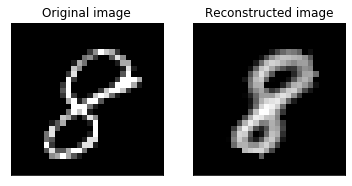

Batch: 33


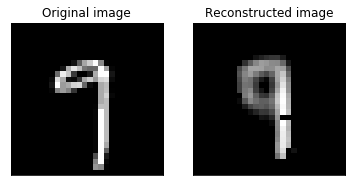

Batch: 34


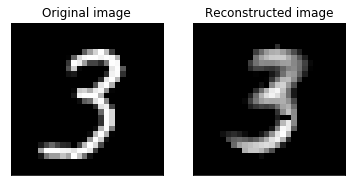

Batch: 35


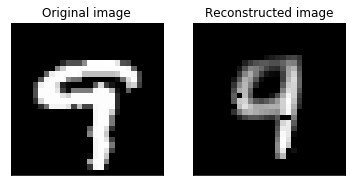

Batch: 36


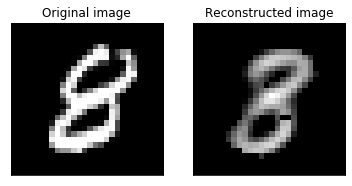

Batch: 37


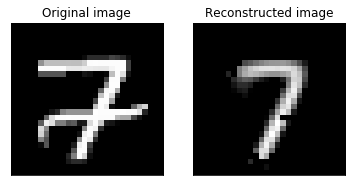

Batch: 38


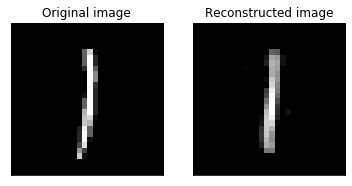

Batch: 39


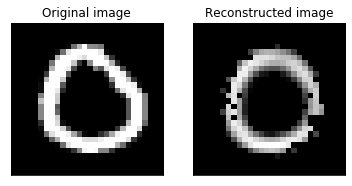

In [11]:
def test():
    model.eval()
    
    X_2D = None # array to store the latent vectors
    labels = None # labels of the test data
    
    for batch_idx, data in enumerate(test_loader):
                    
        x, y = data
        
        # save the original image for later comparison
        img_original = x[0].squeeze() 
        
        # Send the data to the device
        x = x.to(device)
        
        # Resize the input accordingly
        x = x.view(-1, input_dim)
        
        # Encode the data to see how the result looks
        h = model.encoder(x).detach().numpy()
         
        if batch_idx == 0:
            X_2D = h
            labels = y
        else:
            X_2D = np.vstack((X_2D, h))
            labels = np.hstack((labels,  y))
            
        # Get the reconstrunction from the autoencoder
        x_reconstructed = model(x)
        
        if batch_idx < 40:
            # resize the tensor to see the image
            img_reconstructed = x_reconstructed.view(-1, 28, 28).detach().numpy()[0]
            print ("Batch: {}".format(batch_idx))
            # plot the original image and the reconstructed image
            imshow(img_original, img_reconstructed)
    
    return X_2D, labels
        
# Call the testing 
X_2D, labels = test()   

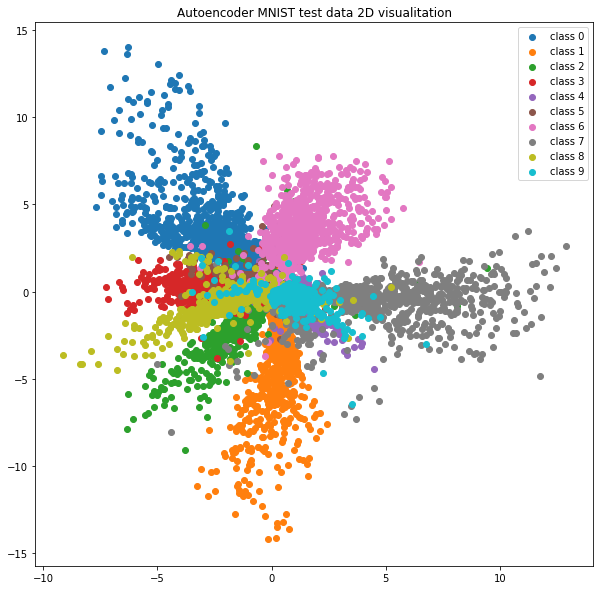

In [9]:
# Autoencoder on MNIST test data
plot_X2D_visualization(X_2D, labels, "Autoencoder MNIST test data 2D visualitation", num_classes = 10)

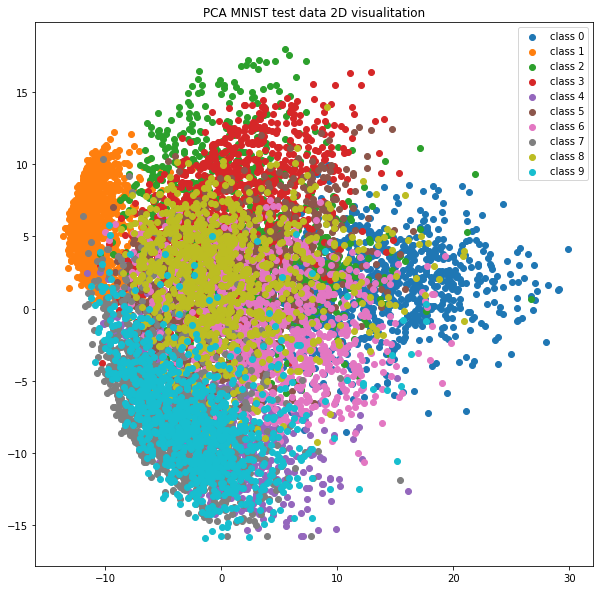

In [12]:
# PCA on MNIST test data
X_test, Y_test = split_data_loader(test_loader)
X_test_2D_pca = run_PCA(X_test)
plot_X2D_visualization(X_test_2D_pca, Y_test, "PCA MNIST test data 2D visualitation", num_classes = 10)

In [8]:
# Auxiliary functions
def sigmoid(x):
    """
    Applies the sigmoid function element-wise to a given numpy array.
    Arguments:
        x: numpy array.
    Output:
        : numpy array with the sigmoid function values computed.
        
    """
    return 1 / (1 + np.exp(-x))

def transform_low_to_high(X_low, F_non_linear, list_W):
    """
    Maps the values from a low dimensional space to a higher dimensional space,
    by means of the following formula (applied multiple times): 
        X_high = F_non_linear (U * F_non_linear (W * X_low))
    where X_high are the resulting vectors in the high dimensional space and
    X_low are the input vectors from the low dimensional space. 
    See below for the other parameters.
    Arguments:
        X_low: data in low dimensional space.
        list_W: List of matrices for the linear transformation to be applied.
        F_non_linear: Non linear function applied in the formula.
    Outputs:
        X_high: data in a higher dimensional space.
    """
    # Apply the transformation to the normalized data
    # by using the matrices stored in the list
    vec_temp = X_low.T
    for W in list_W:
        vec_temp = F_non_linear (W @ vec_temp)
    
    X_high = vec_temp.T
    
    return X_high

def plot_functions(list_functions, title):
    """
    Plots noisy data and function given a list of functions.
    Arguments:
        list_functions: list with all the functions to be plotted.
        title: title of the graphic.

    """
    plt.figure(figsize=(15,10))
    for f in list_functions:
        plt.plot(f.x, f.y_noisy, f.char_to_plot) # Plot noisy data
        plt.plot(f.x, f.y, color = f.color_to_plot) # Plot f(x)
    
    plt.title(title)
    plt.show()
    
    return None

def normalize_data(X, verbose = False):
    """
    Function to normalize the data by subtracting the mean and dividing by the variance.
    Arguments:
        X: numpy array with the data.
        verbose: bool variable to print out sanity checks.

    """
    mean = np.mean(X, axis = 0)
    var = np.var(X, axis = 0)
    
    if verbose:
        print("Function: ", normalize_data.__name__)
        print("Mean: ", mean)
        print("Varaince: ", var)
    
    X = (X - mean)/var
    
    return X

# Data class

class Data():
    def __init__(self, X_train, Y_train, X_test, Y_test, X_val = None, Y_val = None, batch_size = 128):
        """
        Arguments:
            X_train: training data.
            Y_train: truth training labels.
            X_test: test data.
            Y_test: truth test labels.
            X_val: validation data.
            Y_val: truth validation labels.
            batch_size: size of the batch.
            
        """
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_val = Y_val
        self.Y_test = Y_test
        self.batch_size = batch_size
        self.data = None
        self.labels = None
        self.N = None
        self.num_batches = None
        self.mode = None
        
    
    def set_mode (self, mode, shuffle = True):
        """
        Sets the mode of the data, it could be either train, validation or test mode.
        Arguments:
            mode: string variable to indicate whether the training, 
                validation or test data is required, mode can take one 
                of the following values: {'train', 'validation', 'test'}.
            shuffle: bool variable to indicate if data should be shuffled.
        """
        self.mode = mode
        
        if mode == 'train':
            self.N = len(self.Y_train)
            if shuffle:
                idx = np.random.permutation(self.N)
            else:
                idx = np.arange(self.N)
            self.data = self.X_train[idx]
            self.labels = self.Y_train[idx]
            
        elif mode == 'validation':
            self.N = len(self.Y_val)
            if shuffle:
                idx = np.random.permutation(self.N)
            else:
                idx = np.arange(self.N)
            self.data = self.X_val[idx] 
            self.labels = self.Y_val[idx]

        elif mode == 'test':
            self.N = len(self.Y_test)
            if shuffle:
                idx = np.random.permutation(self.N)
            else:
                idx = np.arange(self.N)
            self.data = self.X_test[idx]
            self.labels = self.Y_test[idx]
        
        # Compute the number of batches given the size 
        # of the data and the size of the batch
        self.num_batches = self.N//self.batch_size
        if self.N % self.batch_size > 0:
            self.num_batches += 1
        
        return None
    
    def get_batch(self):
        """
        Gets batches of a specific size once the mode was set.
        Arguments:
            None.
        Outputs:
            Return a batch from size of batch_size, the batch is a pair (data, labels).
        """
        for idx in range(0, self.N, self.batch_size):
            yield (self.data[idx:min(idx + self.batch_size, self.N)],
                   self.labels[idx:min(idx + self.batch_size, self.N)])


# Function classes
class Function():
    def __init__(self, interval, char_to_plot = 'o', color_to_plot = 'red'):
        """
        Arguments:
            interval: pair [a, b] with the domain of the function.
            char_to_plot: character used to plot noisy data.
            color_to_plot: color used to plot the function.
        """
        self.interval = interval
        self.char_to_plot  = char_to_plot
        self.color_to_plot = color_to_plot
        self.x = None
        self.y = None
        self.vec = None
    
class FunctionSin(Function):
    def __init__(self, amp, frec, interval, shift, char_to_plot, color_to_plot):
        """
        Arguments:
            amp: amplitude of the function.
            frec: frecuency of the function.
            interval: pair [a, b] with the domain of the function.
            shift: numerical value that shifts the function along the y axis
            
        """
        super(FunctionSin, self).__init__(interval, char_to_plot, color_to_plot)
        self.amp  = amp
        self.frec = frec
        self.shift = shift
        self.y_noisy = None
        self.epsilon = None
        
    def generate_data(self,  num_samples=1000):
        """
        Generates the nosy data for the function, given the number of samples.
        Arguments:
            num_samples: number of points which will be uniformly
                 distributed in interval domain of the function.
            
        """
        # Get the extremes of the interval
        a, b = self.interval
        # Generate the points from the interval
        self.x = np.linspace(a, b, num=num_samples)
        
        # Generate some noise from a Gaussian distribution
        self.epsilon = np.random.normal(0, 1, num_samples)
        
        # Compute y = f(x) and the noisy data
        self.y = self.amp*np.sin(2 * np.pi * self.frec * self.x) + self.shift
        self.y_noisy = self.amp*np.sin(2 * np.pi * self.frec * self.x) + self.shift + self.epsilon
        
        self.vec = np.transpose(np.vstack((self.x, self.y_noisy)))
        
        return None

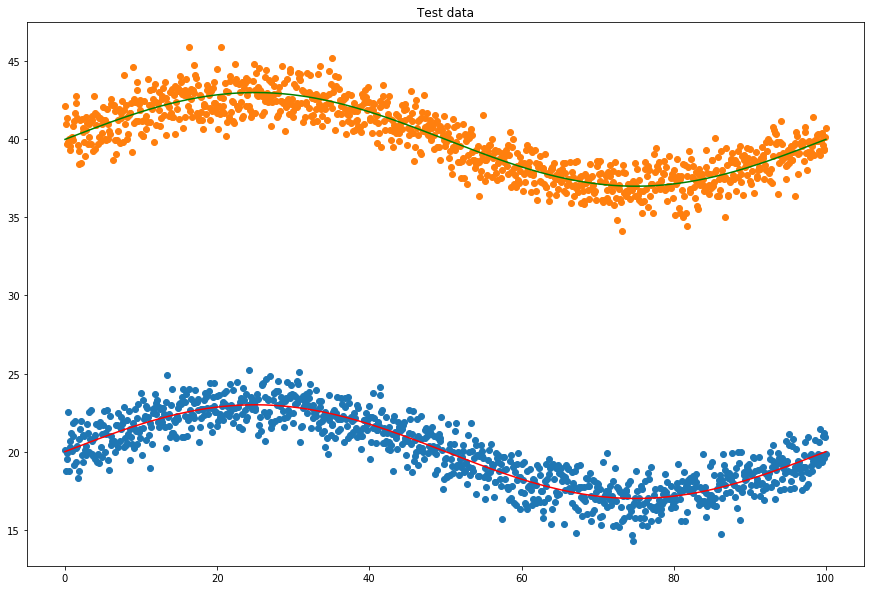

In [9]:
# construct the synthetic data by means of sinusoidal functions

# functions for training data
F1 = FunctionSin(amp = 3, frec = 0.01, interval = (0,100), shift = 20, char_to_plot = 'o', color_to_plot = 'red')
F1.generate_data (num_samples = 100)
F2 = FunctionSin(amp = 3, frec = 0.01, interval = (0,100), shift = 40, char_to_plot = 'o', color_to_plot = 'green')
F2.generate_data (num_samples = 100)
list_functions_train = [F1, F2]

# functions for test data
F3 = FunctionSin(amp = 3, frec = 0.01, interval = (0,100), shift = 20, char_to_plot = 'o', color_to_plot = 'red')
F3.generate_data (num_samples = 1000)
F4 = FunctionSin(amp = 3, frec = 0.01, interval = (0,100), shift = 40, char_to_plot = 'o', color_to_plot = 'green')
F4.generate_data (num_samples = 1000)
list_functions_test = [F3, F4]


# plot the functions
#plot_functions (list_functions_train, 'Training data')
plot_functions (list_functions_test, 'Test data')


Function:  normalize_data
Mean:  [50.         30.03629624]
Varaince:  [850.16835017 105.49422445]


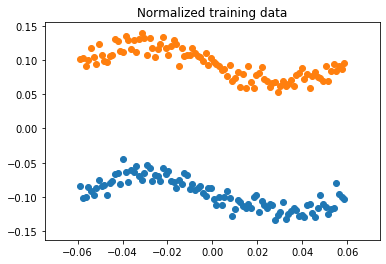

Function:  normalize_data
Mean:  [50.         29.97923856]
Varaince:  [835.00166834 105.21925213]


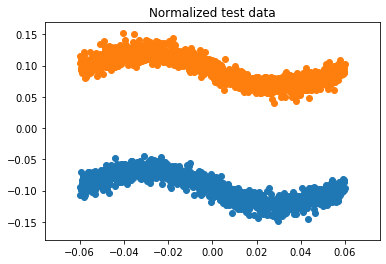

Training data:
Shape X_train: (200, 100)
Shape Y_train: (200,)
Test data:
Shape X_test: (2000, 100)
Shape Y_test: (2000,)


In [10]:
# Define the non linear function as well as 
# the list of matrices to perform the tranformation
F_non_linear = sigmoid

list_dimensions = [(10,2),(50,10),(100,50)] # sizes of the matrices for the transformation
#list_dimensions = [(10,2),(100,10)]
#list_dimensions = [(100,2)]

num_transformations = len(list_dimensions)

list_W = []

# loop to store the linear transformations in a list
for i in range(num_transformations):
    W = np.random.normal(0, 1, size = list_dimensions[i])
    list_W.append(W)
    
# Map the vectors from the low dimensional space
# to the high dimensional space

# training data
X_train_low = np.vstack((F1.vec, F2.vec))
X_train_low_normalized = normalize_data(X_train_low, verbose = True)
X_train = transform_low_to_high(X_train_low_normalized, F_non_linear, list_W)
labels_train0 = np.zeros(F1.vec.shape[0])
labels_train1 = np.ones(F2.vec.shape[0])
Y_train = np.hstack((labels_train0, labels_train1))

# Plot the normalized training data
idx0 = np.where(Y_train==0)
idx1 = np.where(Y_train==1)
plt.scatter(X_train_low_normalized[idx0, 0], X_train_low_normalized[idx0, 1], cmap='viridis')
plt.scatter(X_train_low_normalized[idx1, 0], X_train_low_normalized[idx1, 1], cmap='viridis')
plt.title("Normalized training data")
plt.show()


# test data
X_test_low = np.vstack((F3.vec, F4.vec))
X_test_low_normalized = normalize_data(X_test_low, verbose = True)
X_test = transform_low_to_high(X_test_low_normalized, F_non_linear, list_W)
labels_test0 = np.zeros(F3.vec.shape[0])
labels_test1 = np.ones(F4.vec.shape[0])
Y_test = np.hstack((labels_test0, labels_test1))

# Plot the normalized test data
idx0 = np.where(Y_test==0)
idx1 = np.where(Y_test==1)
plt.scatter(X_test_low_normalized[idx0, 0], X_test_low_normalized[idx0, 1], cmap='viridis')
plt.scatter(X_test_low_normalized[idx1, 0], X_test_low_normalized[idx1, 1], cmap='viridis')
plt.title("Normalized test data")
plt.show()


# Sanity check
print ("Training data:")
print ("Shape X_train: {}".format(X_train.shape))
print ("Shape Y_train: {}".format(Y_train.shape))

print ("Test data:")
print ("Shape X_test: {}".format(X_test.shape))
print ("Shape Y_test: {}".format(Y_test.shape))




X_train_low shape:  (200, 2)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[75.24242424 27.9268568 ]
 [24.75757576 32.14573567]]


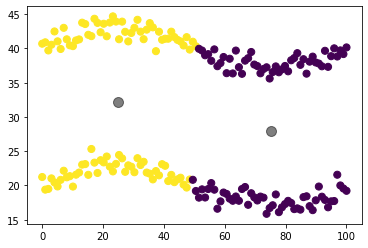

In [11]:
# k-means for the training data
X_train_low  = np.vstack((F1.vec, F2.vec))
print("X_train_low shape: ",X_train_low.shape)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_low)
y_kmeans = kmeans.predict(X_train_low)
print(kmeans.labels_[:100])
print("")
print(kmeans.labels_[-100:])
print(kmeans.cluster_centers_)

centers = kmeans.cluster_centers_
plt.scatter(X_train_low[:, 0], X_train_low[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

X_test_low shape:  (2000, 2)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[74.94263955 27.9107567 ]
 [24.9072543  32.06016867]]


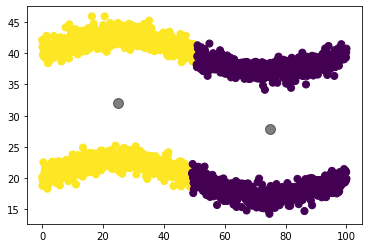

In [12]:
# k-means for the test data
X_test_low = np.vstack((F3.vec, F4.vec))
print("X_test_low shape: ",X_test_low.shape)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_test_low)
y_kmeans = kmeans.predict(X_test_low)

print(kmeans.labels_[:100])
print("")
print(kmeans.labels_[-100:])
print(kmeans.cluster_centers_)

centers = kmeans.cluster_centers_
plt.scatter(X_test_low[:, 0], X_test_low[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

Shape X_train:  (200, 100)
Shape Y_train:  (200,)
Shape X_test:  (2000, 100)
Shape Y_test:  (2000,)
Train Epoch: 0 [0/200 (0%)]	Loss: 0.002904
====> Epoch: 0 Average loss: 0.0037
Train Epoch: 1 [0/200 (0%)]	Loss: 0.002813
====> Epoch: 1 Average loss: 0.0036
Train Epoch: 2 [0/200 (0%)]	Loss: 0.002733
====> Epoch: 2 Average loss: 0.0035
Train Epoch: 3 [0/200 (0%)]	Loss: 0.002649
====> Epoch: 3 Average loss: 0.0034
Train Epoch: 4 [0/200 (0%)]	Loss: 0.002562
====> Epoch: 4 Average loss: 0.0032
Train Epoch: 5 [0/200 (0%)]	Loss: 0.002464
====> Epoch: 5 Average loss: 0.0031
Train Epoch: 6 [0/200 (0%)]	Loss: 0.002356
====> Epoch: 6 Average loss: 0.0030
Train Epoch: 7 [0/200 (0%)]	Loss: 0.002238
====> Epoch: 7 Average loss: 0.0028
Train Epoch: 8 [0/200 (0%)]	Loss: 0.002109
====> Epoch: 8 Average loss: 0.0027
Train Epoch: 9 [0/200 (0%)]	Loss: 0.001957
====> Epoch: 9 Average loss: 0.0024
Train Epoch: 10 [0/200 (0%)]	Loss: 0.001779
====> Epoch: 10 Average loss: 0.0022
Train Epoch: 11 [0/200 (0%)]	

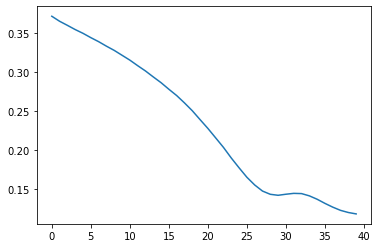

In [19]:
# Define the lists with the sizes for the layers
# of the encoder and decoder

encoder_layer_sizes = [100, 64, 32]
decoder_layer_sizes = [32, 64, 100]

#encoder_layer_sizes = [100, 64]
#decoder_layer_sizes = [64, 100]

#encoder_layer_sizes = [100]
#decoder_layer_sizes = [100]

#encoder_layer_sizes = [100, 50, 10]
#decoder_layer_sizes = [10, 50, 100]

# Define the dimension of the latent space and the input space
latent_dim = 2
input_dim  = 100

# Define the model as an autoencoder
model = AE(input_dim = input_dim, encoder_layer_sizes=encoder_layer_sizes, 
           decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)

model = model.to(device)

# Use Adam optmizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Shape X_train: ", X_train.shape)

print("Shape Y_train: ", Y_train.shape)

print("Shape X_test: ", X_test.shape)

print("Shape Y_test: ", Y_test.shape)

# Load the data by defining an instance of the class Data
data_set = Data(X_train, Y_train, X_test, Y_test)

# Training of the AE
def train(num_epochs):
    model.train()
    data_set.set_mode(mode = 'train')
    list_loss = []
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, data_batch in enumerate(data_set.get_batch()):
            
            # get the data and labels from the generator get_batch
            x, y = data_batch
            
            # convert the numpy arrays into Pytorch tensors
            x = torch.Tensor(x)
            y = torch.Tensor(y)
            
            #print("x shape: ", x.shape)
            #print("y shape: ", y.shape)
            
            x = x.to(device)
            
            # Resize the input accordingly
            x = x.view(-1, input_dim)
            optimizer.zero_grad()
            
            # Get the reconstrunction from the autoencoder
            x_reconstructed = model(x)
            
            # Compute the loss of the batch
            loss = loss_function(x, x_reconstructed, model, lambda_ = 1e-4, regularization = 'L1')
            
            list_loss.append(loss)
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * data_set.batch_size, data_set.N,
                        100. * batch_idx /data_set.num_batches , loss.item() / data_set.batch_size))
        
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / data_set.N))
    
    plt.plot(list_loss)

# Call the training 
num_epochs = 20
train(num_epochs) 

In [20]:
def test(mode_forced):
    model.eval()
    data_set.set_mode(mode = mode_forced)
    X_2D = None
    for batch_idx, data in enumerate(data_set.get_batch()):
        
        #print ("batch_idx: ", batch_idx)
        # get the data and labels from the generator get_batch
        x, y = data
              
        # convert the numpy arrays into Pytorch tensors
        x = torch.Tensor(x)
        y = torch.Tensor(y)
            
        #print("x shape: ", x.shape)
        #print("y shape: ", y.shape)
        
        # Send the data to the device
        x = x.to(device)
        
        # Resize the input accordingly
        x = x.view(-1, input_dim)
        
        # Encode the data to see how the result looks
        h = model.encoder(x).detach().numpy()
        
        #if batch_idx < 10:
        #    print(h)
        
        if batch_idx == 0:
            X_2D = h
        else:
            X_2D = np.vstack((X_2D, h))
       
        # Get the reconstrunction from the autoencoder
        x_reconstructed = model(x)
        
#         if batch_idx < 5:
#             print("x reconstructed: ")
#             print(x_reconstructed)
#             print("x original: ")
#             print(x)
    
    return X_2D

X_2D shape:  (200, 2)


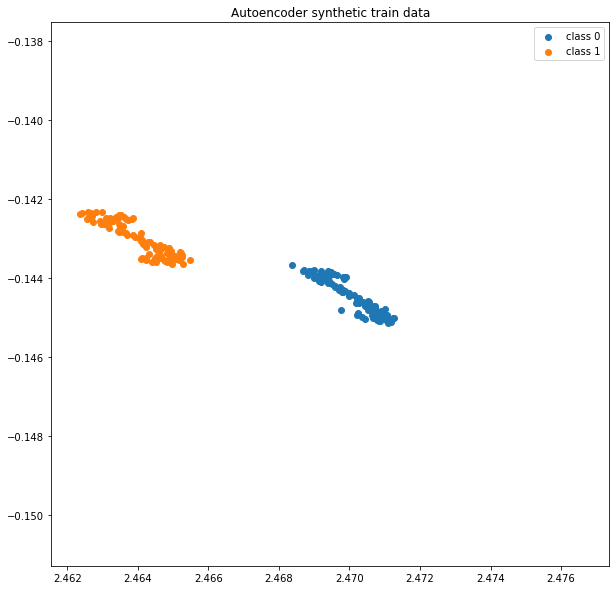

In [21]:
# Call the testing with the train data set
X_2D = test('train')
print("X_2D shape: ", X_2D.shape)
plot_X2D_visualization(X_2D, data_set.labels, "Autoencoder synthetic train data", num_classes = 2)

X_2D shape:  (2000, 2)


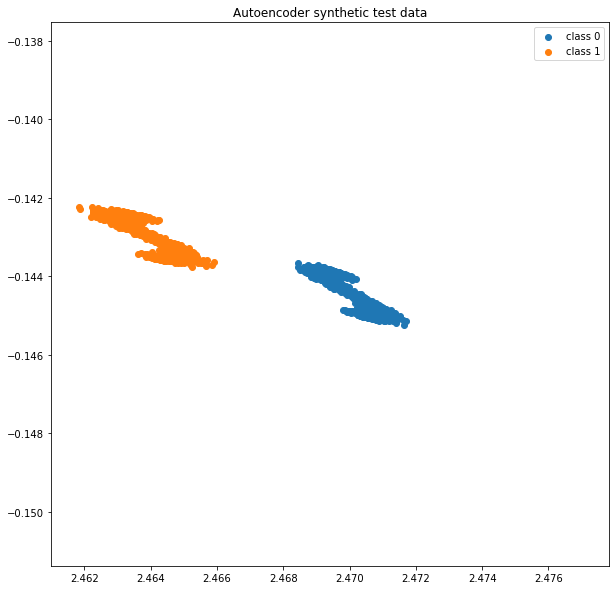

In [22]:
# Call the testing with the test data set
X_2D = test('test')
print("X_2D shape: ", X_2D.shape)
plot_X2D_visualization(X_2D, data_set.labels, "Autoencoder synthetic test data", num_classes = 2)

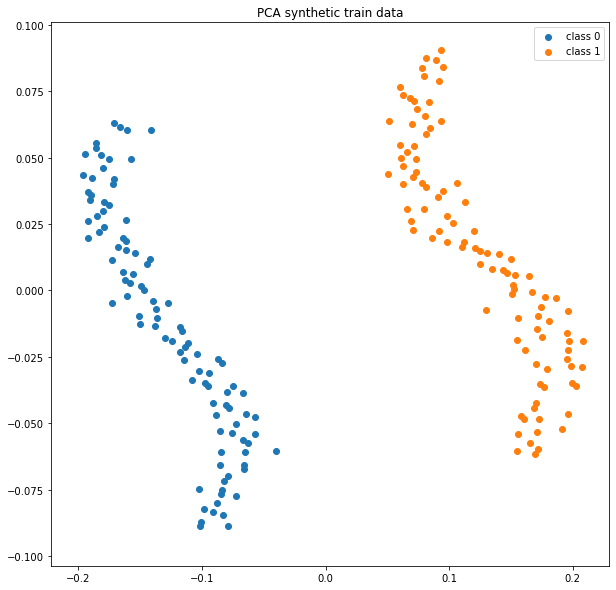

In [23]:
data_set.set_mode(mode = 'train')
X_2D_pca = run_PCA(data_set.data)
plot_X2D_visualization(X_2D_pca, data_set.labels, "PCA synthetic train data", num_classes = 2)

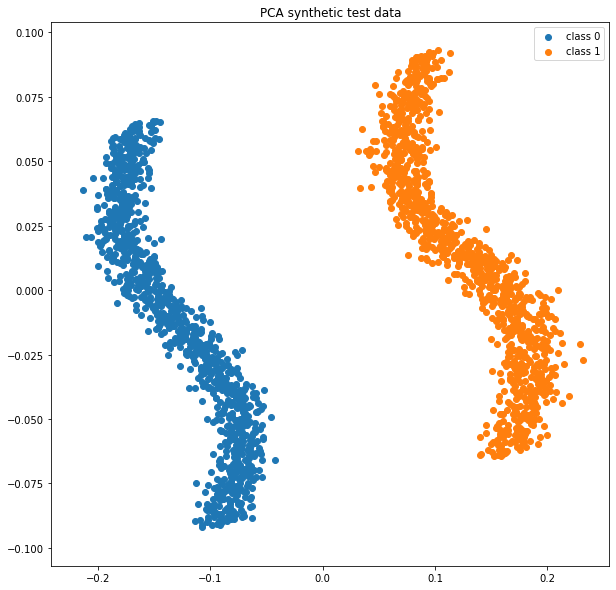

In [24]:
data_set.set_mode(mode = 'test')
X_2D_pca = run_PCA(data_set.data)
plot_X2D_visualization(X_2D_pca, data_set.labels, "PCA synthetic test data", num_classes = 2)

In [ ]:
# Implementation stuff

# comment on classes definition

# comment on functions definition
# make a section for hyperparameters

# General ideas

# check how is the space in R2 for the MNIST dataset ---> DONE

# Make push git

# Normalize data from MNIST

# add ReduceLROnPlateau (WITH VAL SET)

# consider other kind of initialization
